In [19]:
# Training variables
rolling_mean = 7
lag = 8

## Import data from AWS S3

In [20]:
import sys
sys.path.insert(0, '/home/khiem/Dropbox/Education/Drexel/DSCI-591/Project/Walmart-Strategic-Sales-Forecasting')

In [21]:
import boto3
import pandas as pd

bucket = 'dsci-632'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket="dsci-632", Key="CA_1_sales_data.csv")
df = pd.read_csv(obj['Body'], index_col=0, parse_dates=True) # 'Body' is a keyword
print(df.head())

            wm_yr_wk  wday  month  year event_name_1 event_type_1  \
2011-01-29     11101     1      1  2011         None         None   
2011-01-30     11101     2      1  2011         None         None   
2011-01-31     11101     3      1  2011         None         None   
2011-02-01     11101     4      2  2011         None         None   
2011-02-02     11101     5      2  2011         None         None   

           event_name_2 event_type_2      cpi  unemployment_rate  gas_price  \
2011-01-29         None         None  221.187                9.1      3.163   
2011-01-30         None         None  221.187                9.1      3.163   
2011-01-31         None         None  221.187                9.1      3.155   
2011-02-01         None         None  221.898                9.0      3.155   
2011-02-02         None         None  221.898                9.0      3.155   

            snap_ca  ca_walmart  ca_hobbies  ca_household  ca_foods  \
2011-01-29        0       39.50       2

## Data Processing

In [22]:
from data_processing.pre_modeling import pre_modeling

df_processed = pre_modeling(df)

## Data Analysis

In [23]:
timeseries_cols = ['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price']
time_cols = ['wm_yr_wk', 'wday', 'day', 'month', 'year']
target_col = ['store_sales']
cat_cols = [col for col in df_processed.columns if col not in timeseries_cols + time_cols + target_col] # extract the remaining columns

In [24]:
df_used = df_processed[timeseries_cols+time_cols+cat_cols+target_col]
df_used = df_used.rolling(rolling_mean).mean().dropna()

In [25]:
nobs = 30
df_original = df_used
df_test = df_used[-nobs:]
df_train = df_used[0:-nobs]

print(df_train.columns)

Index(['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies',
       'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price',
       'wm_yr_wk', 'wday', 'day', 'month', 'year', 'snap_ca',
       'event_name_1_chanukah end', 'event_name_1_christmas',
       'event_name_1_cinco de mayo', 'event_name_1_columbusday',
       'event_name_1_easter', 'event_name_1_eid al-fitr',
       'event_name_1_eidaladha', 'event_name_1_father's day',
       'event_name_1_halloween', 'event_name_1_independenceday',
       'event_name_1_laborday', 'event_name_1_lentstart',
       'event_name_1_lentweek2', 'event_name_1_martinlutherkingday',
       'event_name_1_memorialday', 'event_name_1_mother's day',
       'event_name_1_nbafinalsend', 'event_name_1_nbafinalsstart',
       'event_name_1_newyear', 'event_name_1_none',
       'event_name_1_orthodoxchristmas', 'event_name_1_orthodoxeaster',
       'event_name_1_pesach end', 'event_name_1_presidentsday',
       'event_name_1_purim 

In [26]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value > sig:
        return True
    else:
        return False

def adfuller_test_all(df, sig=0.05):
    non_stationary = []
    stationary = []
    for name, column in df_train.iteritems():
        if adfuller_test(column, name=column.name):
            non_stationary.append(column.name)
        else:
            stationary.append(column.name)

    print('Non-stationary:', non_stationary)
    print('Stationary:', stationary)

adfuller_test_all(df_train)

/home/khiem/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Non-stationary: ['cpi', 'unemployment_rate', 'gas_price', 'median_price', 'min_price', 'max_price', 'wm_yr_wk', 'year', 'store_sales']
Stationary: ['ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'wday', 'day', 'month', 'snap_ca', 'event_name_1_chanukah end', 'event_name_1_christmas', 'event_name_1_cinco de mayo', 'event_name_1_columbusday', 'event_name_1_easter', 'event_name_1_eid al-fitr', 'event_name_1_eidaladha', "event_name_1_father's day", 'event_name_1_halloween', 'event_name_1_independenceday', 'event_name_1_laborday', 'event_name_1_lentstart', 'event_name_1_lentweek2', 'event_name_1_martinlutherkingday', 'event_name_1_memorialday', "event_name_1_mother's day", 'event_name_1_nbafinalsend', 'event_name_1_nbafinalsstart', 'event_name_1_newyear', 'event_name_1_none', 'event_name_1_orthodoxchristmas', 'event_name_1_orthodoxeaster', 'event_name_1_pesach end', 'event_name_1_presidentsday', 'event_name_1_purim end', 'event_name_1_ramadan starts', 'event_name_1_stpatricksday', 

In [27]:
df_train = df_train.diff().dropna()
adfuller_test_all(df_train)

/home/khiem/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Non-stationary: []
Stationary: ['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price', 'wm_yr_wk', 'wday', 'day', 'month', 'year', 'snap_ca', 'event_name_1_chanukah end', 'event_name_1_christmas', 'event_name_1_cinco de mayo', 'event_name_1_columbusday', 'event_name_1_easter', 'event_name_1_eid al-fitr', 'event_name_1_eidaladha', "event_name_1_father's day", 'event_name_1_halloween', 'event_name_1_independenceday', 'event_name_1_laborday', 'event_name_1_lentstart', 'event_name_1_lentweek2', 'event_name_1_martinlutherkingday', 'event_name_1_memorialday', "event_name_1_mother's day", 'event_name_1_nbafinalsend', 'event_name_1_nbafinalsstart', 'event_name_1_newyear', 'event_name_1_none', 'event_name_1_orthodoxchristmas', 'event_name_1_orthodoxeaster', 'event_name_1_pesach end', 'event_name_1_presidentsday', 'event_name_1_purim end', 'event_name_1_ramadan starts', 'event_name_1_stpatricksday', 'event_name_1

In [28]:
from statsmodels.tsa.api import VAR

df_train_fit = df_train[timeseries_cols+target_col]
model = VAR(df_train_fit)
x = model.select_order(maxlags=12)
x.summary()

/home/khiem/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-45.77,-45.74,1.325e-20,-45.76
1,-55.38,-54.99*,8.917e-25,-55.23
2,-55.41,-54.66,8.664e-25,-55.13
3,-55.42,-54.32,8.563e-25,-55.01
4,-55.42,-53.97,8.516e-25,-54.89
5,-55.43,-53.63,8.443e-25,-54.77
6,-55.51,-53.35,7.821e-25,-54.71
7,-56.48,-53.97,2.951e-25,-55.56
8,-57.69*,-54.82,8.805e-26*,-56.64*
9,-57.65,-54.42,9.215e-26,-56.46


In [29]:
model_fitted = model.fit(lag)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 08, Aug, 2022
Time:                     00:54:22
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -54.8430
Nobs:                     1896.00    HQIC:                  -56.6528
Log likelihood:           26092.3    FPE:                8.67567e-26
AIC:                     -57.7074    Det(Omega_mle):     5.23792e-26
--------------------------------------------------------------------
Results for equation cpi
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.001958         0.000466            4.200           0.000
L1.cpi                       0.907111         0.022742           39.887           0.000
L1.unemployment_rate         0.024

In [30]:
print(model_fitted.params["store_sales"])

const                    -1.807796
L1.cpi                  178.391626
L1.unemployment_rate   -649.617297
L1.gas_price           -169.599005
L1.ca_walmart            -1.172540
                           ...    
L8.ca_foods               2.008596
L8.median_price         731.188784
L8.min_price            334.273465
L8.max_price            -38.242112
L8.store_sales            0.256907
Name: store_sales, Length: 89, dtype: float64


In [31]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_train_fit.values[-lag_order:]
forecast_input

8


array([[ 0.00000000e+00,  0.00000000e+00, -1.71428571e-03,
        -5.14285714e-02,  1.44000000e+00,  4.07142857e+00,
         2.82857143e-01,  0.00000000e+00, -2.77555756e-17,
         0.00000000e+00, -1.05285714e+02],
       [ 0.00000000e+00,  0.00000000e+00, -1.71428571e-03,
        -2.05714286e-01,  5.14285714e-02,  1.05857143e+00,
         1.03714286e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -9.64285714e+01],
       [ 0.00000000e+00,  0.00000000e+00, -1.71428571e-03,
         3.60000000e-01, -7.71428571e-01, -1.30285714e+00,
         2.82857143e-01,  4.44089210e-16,  2.77555756e-17,
         0.00000000e+00, -2.14285714e+00],
       [ 0.00000000e+00,  0.00000000e+00,  9.57142857e-03,
        -2.05714286e-01, -5.14285714e-02,  1.22142857e+00,
         8.48571429e-01, -4.44089210e-16,  0.00000000e+00,
         0.00000000e+00, -1.98571429e+01],
       [ 0.00000000e+00,  0.00000000e+00,  9.57142857e-03,
        -1.02857143e-01,  1.69714286e+00, -8.95714286e-01,
  

In [32]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_original.index[-nobs:], columns=df_train_fit.columns + '_1d')
df_forecast["store_sales_1d"]

2016-04-23    34.239161
2016-04-24   -12.082633
2016-04-25     9.431138
2016-04-26   -26.953068
2016-04-27   -25.952151
2016-04-28   -10.680484
2016-04-29   -41.579139
2016-04-30   -17.930551
2016-05-01     5.512686
2016-05-02   -11.062028
2016-05-03    13.892785
2016-05-04    10.683691
2016-05-05     3.368953
2016-05-06    22.498827
2016-05-07     5.106709
2016-05-08    -4.837385
2016-05-09     5.778133
2016-05-10    -9.976333
2016-05-11    -5.782448
2016-05-12    -2.680568
2016-05-13   -13.304861
2016-05-14    -1.867662
2016-05-15     1.689139
2016-05-16    -3.720704
2016-05-17     6.021455
2016-05-18     2.488526
2016-05-19     1.754335
2016-05-20     7.450628
2016-05-21     0.873440
2016-05-22     0.267815
Name: store_sales_1d, dtype: float64

In [33]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_original[0:-nobs][timeseries_cols+target_col], df_forecast)        
df_results.head(10)

,cpi_1d,unemployment_rate_1d,gas_price_1d,ca_walmart_1d,ca_hobbies_1d,ca_household_1d,ca_foods_1d,median_price_1d,min_price_1d,max_price_1d,...,unemployment_rate_forecast,gas_price_forecast,ca_walmart_forecast,ca_hobbies_forecast,ca_household_forecast,ca_foods_forecast,median_price_forecast,min_price_forecast,max_price_forecast,store_sales_forecast
2016-04-23,-0.000865,0.000041,0.009329,0.241933,0.239973,-0.614956,0.224100,0.000155,-0.000064,-0.000349,...,5.100041,2.230186,29.196219,30.017116,38.959330,60.284100,3.480155,0.229936,29.969651,4512.382018
2016-04-24,0.003336,-0.000997,0.009182,0.090293,0.525098,0.312830,0.440039,0.000319,-0.000128,0.001085,...,5.099044,2.239368,29.286512,30.542214,39.272160,60.724139,3.480474,0.229808,29.970735,4500.299385
2016-04-25,0.004662,-0.000902,0.007496,0.346932,-0.047986,-1.142756,-0.037041,0.000468,-0.000159,-0.001041,...,5.098142,2.246865,29.633443,30.494228,38.129404,60.687097,3.480942,0.229649,29.969694,4509.730523
2016-04-26,0.005661,-0.001448,0.006819,0.263297,-0.733121,0.187370,-0.144503,0.000404,-0.000205,-0.004757,...,5.096694,2.253684,29.896740,29.761107,38.316774,60.542594,3.481346,0.229444,29.964938,4482.777455
2016-04-27,0.010339,-0.001912,0.005902,-0.046585,-0.387669,-0.284775,-0.028061,0.000297,-0.000194,-0.004699,...,5.094782,2.259586,29.850155,29.373438,38.032000,60.514534,3.481643,0.229250,29.960239,4456.825304
2016-04-28,0.010982,-0.001817,0.005404,0.009144,0.771197,0.230777,-0.015803,0.000282,-0.000300,-0.004093,...,5.092966,2.264990,29.859298,30.144635,38.262777,60.498731,3.481926,0.228950,29.956146,4446.144820
2016-04-29,0.013157,-0.002058,0.004960,0.139758,-0.274727,1.488234,-0.059867,0.000346,-0.000166,-0.003894,...,5.090907,2.269949,29.999057,29.869908,39.751011,60.438864,3.482271,0.228784,29.952252,4404.565681
2016-04-30,0.017928,-0.002487,0.004374,-0.071245,-0.280041,0.174190,-0.169786,0.000263,-0.000082,-0.004755,...,5.088421,2.274324,29.927812,29.589867,39.925201,60.269077,3.482534,0.228702,29.947497,4386.635130
2016-05-01,0.017958,-0.002264,0.003715,-0.003652,-0.281493,-0.017869,-0.192206,0.000100,-0.000142,-0.005899,...,5.086156,2.278039,29.924159,29.308374,39.907331,60.076871,3.482635,0.228561,29.941598,4392.147816
2016-05-02,0.018567,-0.002637,0.003344,-0.084132,-0.050375,0.570404,0.073179,-0.000044,-0.000182,-0.003338,...,5.083519,2.281383,29.840027,29.257998,40.477736,60.150050,3.482590,0.228379,29.938260,4381.085788


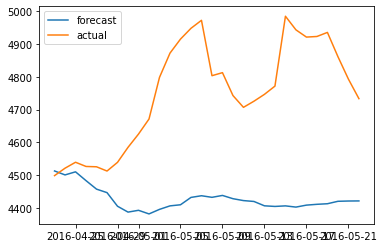

In [34]:
import matplotlib.pyplot as plt

plt.plot(df_results.index, df_results["store_sales_forecast"], label = "forecast")
plt.plot(df_test.index, df_test["store_sales"], label = "actual")
plt.legend()
plt.show()


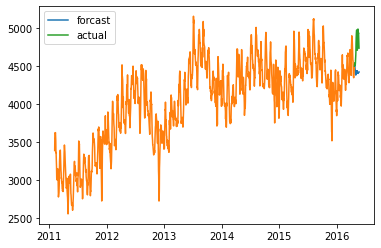

In [35]:
plt.plot(df_results["store_sales_forecast"].index, df_results["store_sales_forecast"], label = "forcast")
plt.plot(df_original["store_sales"][0:-nobs].index, df_original["store_sales"][0:-nobs])
plt.plot(df_test.index, df_test["store_sales"], label = "actual")
plt.legend()
plt.show()

In [36]:
# evaluate the model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

error_mse = mean_squared_error(df_test["store_sales"], df_results["store_sales_forecast"])
error_mae = mean_absolute_error(df_test["store_sales"], df_results["store_sales_forecast"])
error_r2 = r2_score(df_test["store_sales"], df_results["store_sales_forecast"])
print("MSE:", error_mse)
print("MAE:", error_mae)
print("R2:", error_r2)


MSE: 135588.1248152364
MAE: 322.93877500396314
R2: -4.375927051365832
